$$
\begin{aligned}
\mu_{\mathrm{A}}\left(\mathrm{c}_{\mathrm{A}}\right)= & \mu_{\mathrm{A}}^0+\mathrm{k}_{\mathrm{B}} \mathrm{T} \ln \left(\frac{\mathrm{c}_{\mathrm{A}}}{\mathrm{c}_{\mathrm{A}}^0}\right) \\
& +\mathrm{k}_{\mathrm{B}} \mathrm{T} \int_{\ln \mathrm{c}_{\mathrm{A}}^0}^{\ln \mathrm{c}_{\mathrm{A}}} \mathrm{d} \ln \left(\mathrm{c}_{\mathrm{A}}\right)\left[\frac{1}{\mathrm{~S}_{\mathrm{AA}}^0-\mathrm{S}_{\mathrm{AB}}^0 \sqrt{\mathrm{c}_{\mathrm{A}} / \mathrm{c}_{\mathrm{B}}}}-1\right]
\end{aligned}
$$

the non-ideal part refers to excess chemcial potential:
$$
\mathrm{k}_{\mathrm{B}} \mathrm{T} \int_{\ln \mathrm{c}_{\mathrm{A}}^0}^{\ln \mathrm{c}_{\mathrm{A}}} \mathrm{d} \ln \left(\mathrm{c}_{\mathrm{A}}\right)\left[\frac{1}{\mathrm{~S}_{\mathrm{AA}}^0-\mathrm{S}_{\mathrm{AB}}^0 \sqrt{\mathrm{c}_{\mathrm{A}} / \mathrm{c}_{\mathrm{B}}}}-1\right]
$$

In [11]:
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt
from math import pi, isinf
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
from scipy.optimize import curve_fit
import scipy.constants
import math
import numpy as np

def excess_mu(ca,saa,sab,nratio,c0,kbt):
    # ca, nratio are 1-D array with N-dim
    # saa,sab are (2,N) array, [S, S_error]
    integrand = 1./(saa[:,0]-sab[:,0]*(nratio)**0.5) -1.
    integrand_error = 0.5*abs(1./((saa[:,0]-saa[:,1])-(sab[:,0]+sab[:,1])*(nratio)**0.5)-1./((saa[:,0]+saa[:,1])-(sab[:,0]-sab[:,1])*(nratio)**0.5))
    logca = np.log(ca)
    index = np.argwhere(integrand == float("inf"))
    integrand[index] = float('nan')
    
    mask = ~np.isnan(integrand)

    int_func = interp1d(logca[mask], integrand[mask], kind='linear',fill_value='extrapolate')
    int_error_func = interp1d(logca[mask], integrand_error[mask], kind='linear',fill_value='extrapolate')
    
    # integrate
    ca_mu = []
    n_sample = 0
    for i,a in enumerate(logca):
        if ca[i] > 0:
            n_sample+=1
            mu_now = kbt*quad(int_func, np.log(c0), a)[0]
            if n_sample >= 2:
                mu_error_now = kbt*quad(int_error_func, np.log(c0), a)[0]/(n_sample-1)**0.5
            else:
                mu_error_now = kbt*quad(int_error_func, np.log(c0), a)[0]
            ca_mu.append([ca[i],mu_now, mu_error_now])
        
    return np.asarray(ca_mu)
    

# Read in data

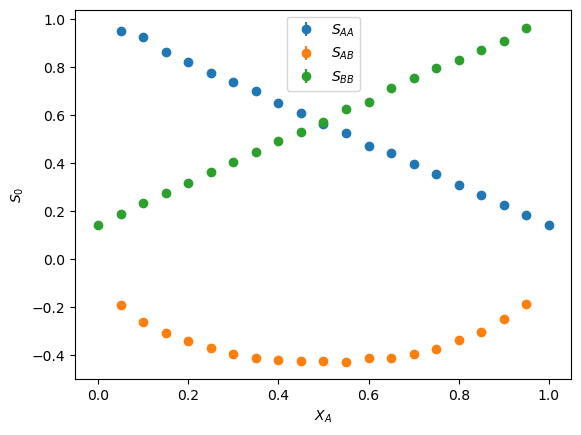

In [12]:
Temp = 1.2
N_A = scipy.constants.Avogadro

flag_box = ["AA","AB","BB"]
data = np.loadtxt("./LJ_S0_data_sum.txt")

# Rename every var
# mol frac of A paricles 
X_A  = data[::,0]
S_AA = data[:,1:3]
S_AB = data[:,3:5]
S_BB = data[:,5:7]

#compute the concentrition
vol_list = ['46740.536', '46702.929', '46940.069', '46777.225', '46868.228', '46810.31', '47000.639', '46841.816', '46963.354', '46963.354', '47068.412', '47096.167', '47135.511', '47109.139', '47192.731', '47216.936', '47328.919', '47378.922', '47148.088', '47378.351', '47316.911']
vol_sys = np.array(list((map(float, vol_list))))
c_all = np.array((1/N_A*23328)/(vol_sys*1e-27)/100)
c_A_mol_L = np.array((X_A/N_A*23328)/(vol_sys*1e-27)/100)
c_B_mol_L = c_all - c_A_mol_L

plt.errorbar(X_A, S_AA[:,0], S_AA[:,1], ls="", marker="o", label="$S_{AA}$")
plt.errorbar(X_A, S_AB[:,0], S_AB[:,1], ls="", marker="o", label="$S_{AB}$")
plt.errorbar(X_A, S_BB[:,0], S_BB[:,1], ls="", marker="o", label="$S_{BB}$")
plt.ylabel("$S_0$")  
plt.xlabel("$X_{A}$") 

plt.legend()
plt.show()

In [13]:
import jax.numpy as jnp
gp_data = dict(jnp.load("./gp_predict_LJ.npz"))

mu_a = gp_data["mu_a"]
mu_a_err = gp_data["mu_a_err"]
mu_b = gp_data["mu_b"]
mu_b_err = gp_data["mu_b_err"]

In [14]:
import warnings
warnings. filterwarnings("ignore")

mu_A_excess = excess_mu(c_A_mol_L, S_AA, S_AB, c_A_mol_L/c_B_mol_L, c_A_mol_L[-1], Temp)
mu_B_excess = excess_mu(c_B_mol_L, S_BB, S_AB, c_B_mol_L/c_A_mol_L, c_B_mol_L[0], Temp)

Text(0.5, 0, '$X_{A}$')

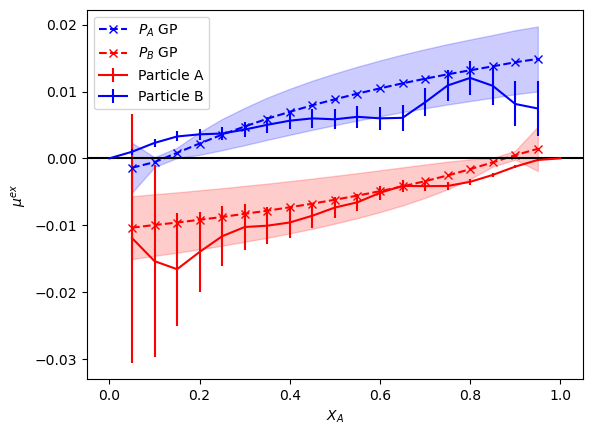

In [17]:
plt.errorbar(X_A[1:], mu_A_excess[:,1], np.abs(mu_A_excess[:,2]), \
             c="red",label = "Particle A")
plt.errorbar(X_A[:-1], mu_B_excess[:,1], np.abs(mu_B_excess[:,2]), \
            c="blue",label = "Particle B")

plt.plot(X_A[1:-1], mu_a, c="b", ls="--", marker="x", label="$P_A$ GP")
plt.fill_between(X_A[1:-1], mu_a-mu_a_err, mu_a+mu_a_err, alpha=0.2, color="b")

plt.plot(X_A[1:-1], mu_b, c="r", ls="--", marker="x", label="$P_B$ GP")
plt.fill_between(X_A[1:-1], mu_b-mu_b_err, mu_b+mu_b_err, alpha=0.2, color="r")

plt.axhline(y=0,c='k')
plt.legend()
plt.xlim(-0.05,1.05)

plt.ylabel("$\mu^{ex}$")  
plt.xlabel("$X_{A}$") 